In [10]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

RESULTS_PATH = "resultsGA"

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [ ]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree


def readGraph(filePath):
    graph = nx.Graph()
    with open(filePath, 'r') as f:
        lines = f.readlines()
    
    edges = []
    numNodes = 0
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        parts = line.split()
        
        
        if 'edge' in parts:
            try:
                
                numNodes = int(parts[2])
            except (IndexError, ValueError):
                pass
            continue

        
        if (parts[0] == 'p' or parts[0] == 'e') and len(parts) >= 3:
            try:
                
                u, v = int(parts[1]), int(parts[2])
                edges.append((u, v))
            except ValueError:
                
                continue
        
        
        elif len(parts) == 2:
            try:
                u, v = int(parts[0]), int(parts[1])
                edges.append((u, v))
            except ValueError:
                continue

    if edges:
        graph.add_edges_from(edges)
        
        if numNodes == 0:
            numNodes = max(max(u, v) for u, v in edges)
        
        
        graph.add_nodes_from(range(1, numNodes + 1))
        
    return graph

def getFitness(chromosome, edges, maxNode):
    conflicts = 0
    nodeMap = {i: [] for i in range(1, maxNode + 1)}
    for i, color in enumerate(chromosome):
        u, v = edges[i]
        nodeMap[u].append(color)
        nodeMap[v].append(color)
    for node in nodeMap:
        colors = nodeMap[node]
        if len(colors) > 1:
            conflicts += (len(colors) - len(set(colors)))
    return conflicts

In [12]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)[::-1] 
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = rank + 1
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]

In [13]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]

In [14]:
def mutationSmart(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
    available = list(set(range(1, delta + 2)) - forbidden)
    if available:
        chromosome[idx] = random.choice(available)
    else:
        chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationRandom(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationSwap(chromosome, edges, maxNode, delta):
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

In [ ]:
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc, numColours):
    edges = list(graph.edges())
    if not edges: return [], 0, []
    maxNode, numEdges = max(graph.nodes()), len(edges)
    population = [[random.randint(1, numColours) for _ in range(numEdges)] for _ in range(popSize)]
    history = []
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        bestFit = min(fitnesses)
        history.append(bestFit)
        if bestFit == 0:
            history.extend([0] * (maxIters - len(history)))
            break
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]]
        while len(newPop) < popSize:
            p1, p2 = selFunc(population, fitnesses), selFunc(population, fitnesses)
            child = crossFunc(p1, p2)
            if random.random() < 0.3:
                child = mutFunc(child, edges, maxNode, numColours)
            newPop.append(child)
        population = newPop
    finalFits = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFits)
    return population[bestIdx], finalFits[bestIdx], history

In [ ]:
def processAndVisualize(filePath):
    graph = readGraph(filePath)
    fileName = os.path.basename(filePath)
    delta = maxNumOfColours(graph)
    if graph.number_of_edges() == 0: return

    
    f_lower = fileName.lower()
    type_info = "Unknown Graph Type"
    theory_note = ""
    is_bipartite = nx.is_bipartite(graph)
    if "completegraph" in f_lower or "k_" in f_lower:
        try:
            n = int(''.join(filter(str.isdigit, fileName)))
            type_info = f"Complete Graph K({n})"
            if n % 2 == 0: theory_note = f"Class 1 (Expected χ' = Δ = {n-1})"
            else: theory_note = f"Class 2 (Expected χ' = Δ + 1 = {n})"
        except: type_info = "Complete Graph"
    elif "bipartite" in f_lower or is_bipartite:
        type_info = "Bipartite Graph"
        theory_note = f"Always Class 1 (Expected χ' = Δ = {delta})"
    elif "petersen" in f_lower or "snark" in f_lower or "flower" in f_lower:
        type_info = "SNARK / Petersen Graph"
        theory_note = f"Class 2 (Expected χ' = Δ + 1 = {delta+1})"
    elif "regular" in f_lower:
        type_info = f"Random Regular Graph (d={delta})"
        theory_note = "Most are Class 1"
    elif "graph" in f_lower:
        type_info = "Random G(n,p) Graph"
        theory_note = "Vizing's Theorem: Class 1 or 2"

    print(f"\n>>> ANALYZING: {fileName}")
    print(f"[TYPE]: {type_info}")
    if theory_note: print(f"[THEORY]: {theory_note}")

    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
    mutations = [mutationRandom, mutationSmart, mutationSwap]

    
    def run_tests(num_cols):
        res_list = []
        for sel in selections:
            for cross in crossovers:
                for mut in mutations:
                    sName = sel.__name__.replace('selection', '')
                    cName = cross.__name__.replace('crossover', '')
                    mName = mut.__name__.replace('mutation', '')
                    t0 = time.perf_counter()
                    sol, fit, hist = runGaModular(graph, 250, 40, sel, cross, mut, num_cols)
                    dt = time.perf_counter() - t0
                    res_list.append({'selection': sName, 'crossover': cName, 'mutation': mName,
                                     'fit': fit, 'time': dt, 'hist': hist, 'sol': sol, 'cols': num_cols})
        return res_list

    # Prvi krug
    allResults = run_tests(delta)
    allResults.sort(key=lambda x: (x['fit'], x['time']))
    
    found_zero = allResults[0]['fit'] == 0
    secondAttemptResults = []

    if not found_zero:
        print(f"!!! Nema nule sa {delta} boja. Pokrećem Delta + 1 = {delta+1}...")
        secondAttemptResults = run_tests(delta + 1)
        secondAttemptResults.sort(key=lambda x: (x['fit'], x['time']))

    
    def prepare_table(results):
        data = []
        for i, r in enumerate(results):
            data.append([i, r['selection'], r['crossover'], r['mutation'], r['fit'], r['cols'], f"{r['time']:.6f}"])
        return data

    headers = ["Rank", "selection", "crossover", "mutation", "num of conf", "colours", "time"]
    
    # Konzola: Top 3
    print(f"Top 3 Combinations for {fileName}:")
    print(tabulate(prepare_table(allResults if found_zero else secondAttemptResults)[:3], headers=headers, tablefmt="fancy_grid"))

    # Fajl: format sa dopisivanjem rezultata
    txtPath = os.path.join(RESULTS_PATH, fileName) 
    with open(txtPath, 'w', encoding='utf-8') as f:
        f.write(f"Graph: {fileName} | Type: {type_info}\nTheory: {theory_note}\nMax Degree (Delta): {delta}\n\n")
        f.write("--- RESULTS FOR DELTA ---\n")
        f.write(tabulate(prepare_table(allResults), headers=headers, tablefmt="fancy_grid"))
        if secondAttemptResults:
            f.write("\n\n--- RESULTS FOR DELTA + 1 ---\n")
            f.write(tabulate(prepare_table(secondAttemptResults), headers=headers, tablefmt="fancy_grid"))
        
        if found_zero: f.write(f"\n\nRESULT: Class 1 found (Index = {delta})")
        elif secondAttemptResults and secondAttemptResults[0]['fit'] == 0: f.write(f"\n\nRESULT: Class 2 found (Index = {delta+1})")
        else: f.write(f"\n\nRESULT: GA failed to find 0 conflicts.")

    
    best = allResults[0] if found_zero or not secondAttemptResults else secondAttemptResults[0]
    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, edge_color=best['sol'], width=2.5, with_labels=True, node_color='lightblue', edge_cmap=plt.cm.rainbow)
    plt.title(f"Winner (Rank 0):\n{best['selection']} + {best['crossover']} + {best['mutation']}")

    plt.subplot(1, 2, 2)
    plot_data = allResults[:3] if found_zero else secondAttemptResults[:3]
    for i, res in enumerate(plot_data):
        label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
        plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
    plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
    plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.8)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    print(f"Full table saved to: {txtPath}")


########################################
# ENTERING FOLDER: experimentalTests
########################################

>>> ANALYZING: completeBipartite10.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 10)
!!! Nema nule sa 10 boja. Pokrećem Delta + 1 = 11...
Top 3 Combinations for completeBipartite10.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │             0 │        11 │ 0.110046 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │             0 │        11 │ 0.113219 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Singl

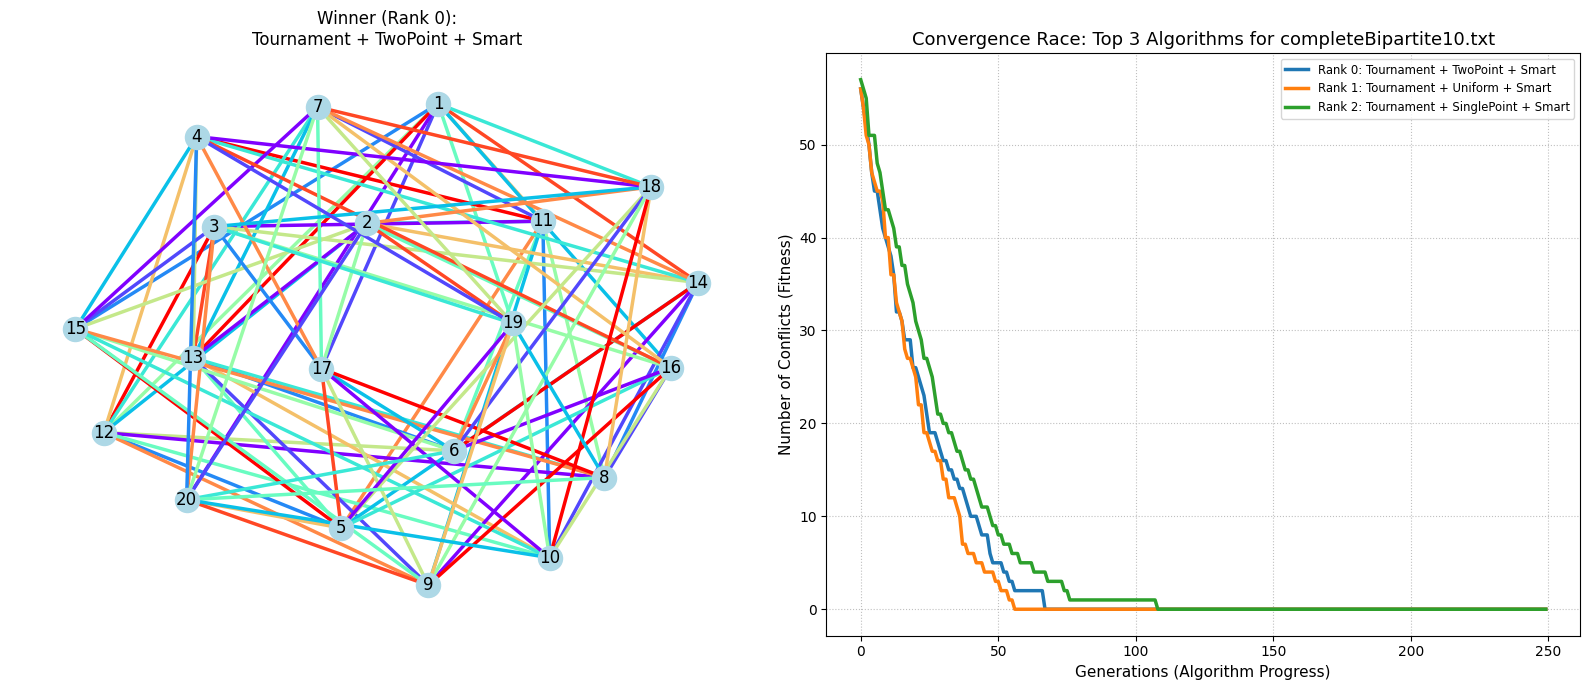

Full table saved to: resultsGA/completeBipartite10.txt

>>> ANALYZING: completeBipartite20.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 20)
!!! Nema nule sa 20 boja. Pokrećem Delta + 1 = 21...
Top 3 Combinations for completeBipartite20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │            13 │        21 │ 1.55499 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │            13 │        21 │ 1.97566 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │            16 │        21 │ 1.12192 │
╘════════╧══

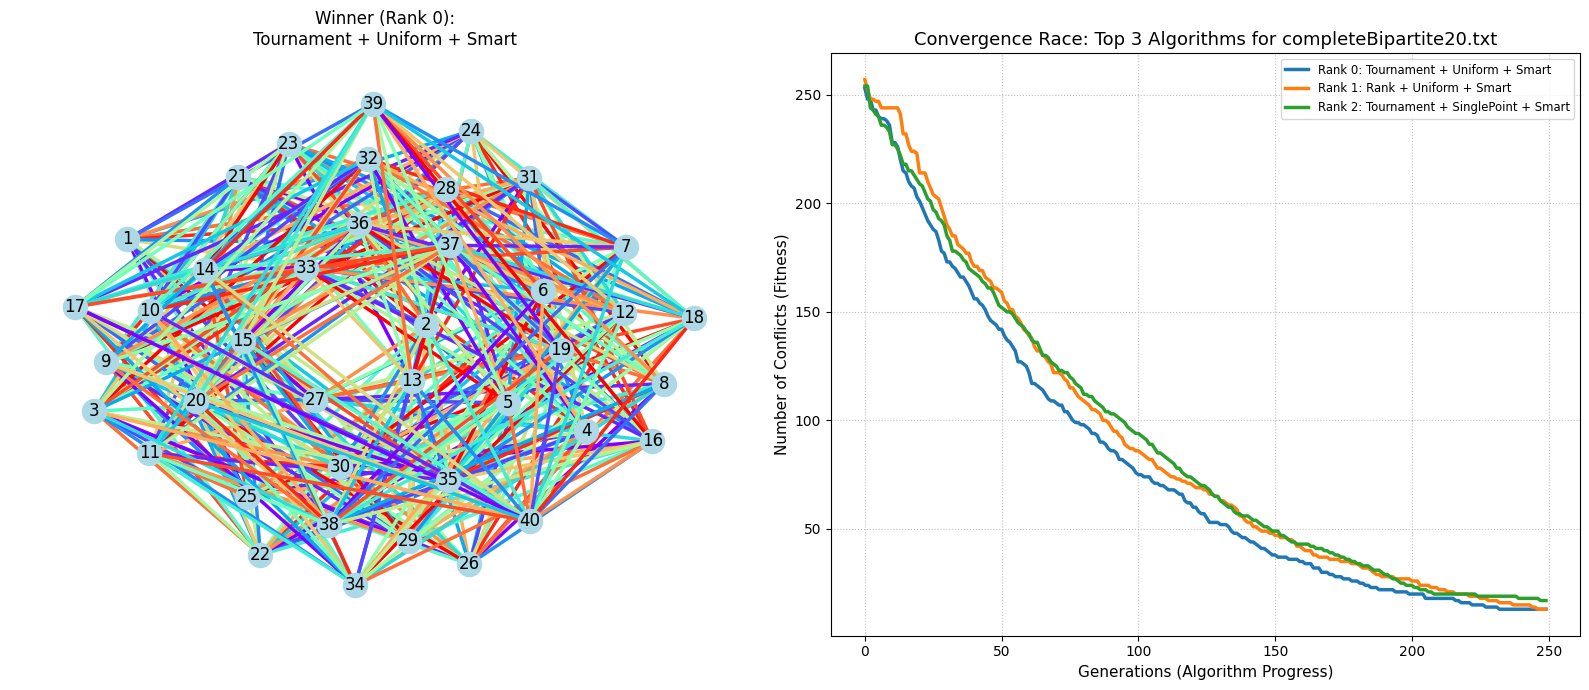

Full table saved to: resultsGA/completeBipartite20.txt

>>> ANALYZING: completeGraph11.txt
[TYPE]: Complete Graph K(11)
[THEORY]: Class 2 (Expected χ' = Δ + 1 = 11)
!!! Nema nule sa 10 boja. Pokrećem Delta + 1 = 11...
Top 3 Combinations for completeGraph11.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │             0 │        11 │ 0.050718 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ SinglePoint │ Smart      │             0 │        11 │ 0.063393 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Roulette    │ TwoPoint    │ Smart      │             0 │        11 │ 0.100807 │
╘════════╧

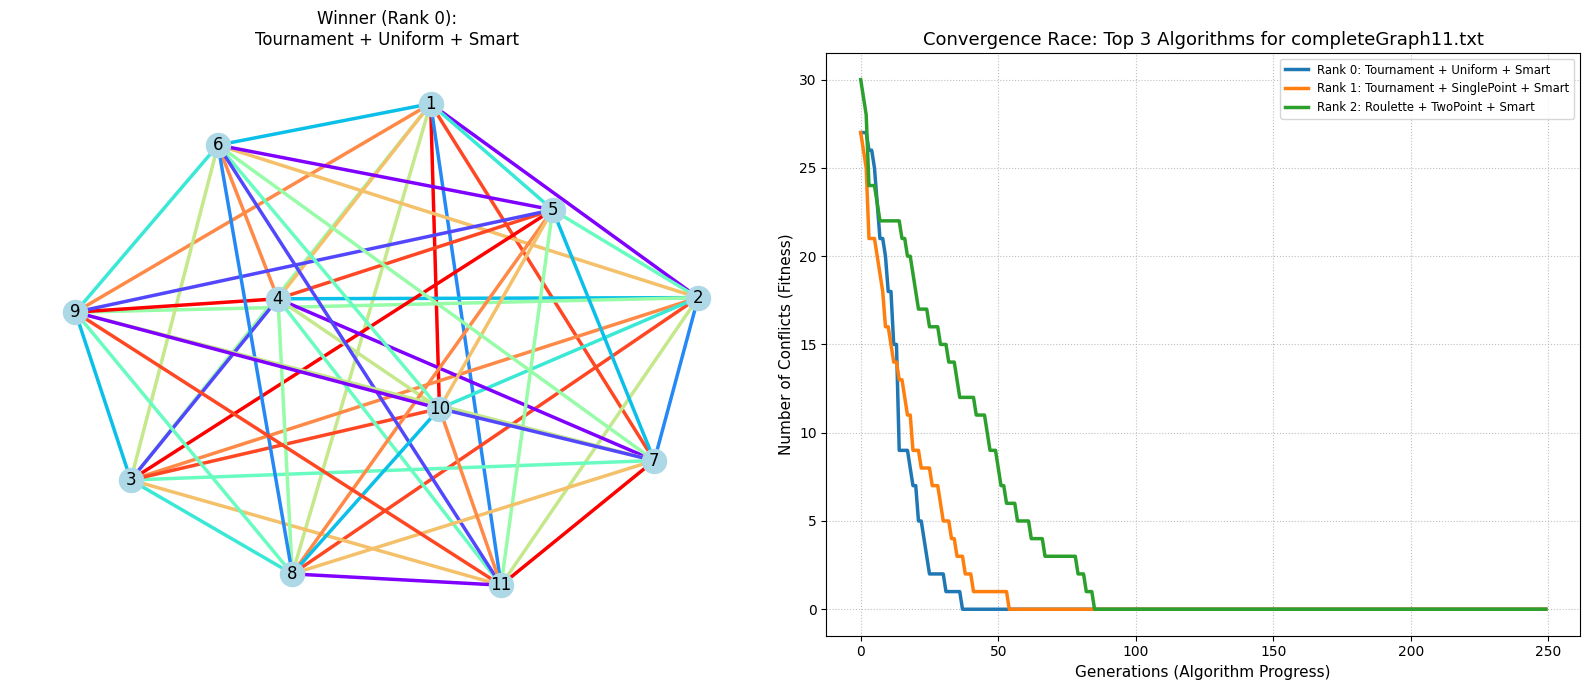

Full table saved to: resultsGA/completeGraph11.txt

>>> ANALYZING: completeGraph20.txt
[TYPE]: Complete Graph K(20)
[THEORY]: Class 1 (Expected χ' = Δ = 19)
!!! Nema nule sa 19 boja. Pokrećem Delta + 1 = 20...
Top 3 Combinations for completeGraph20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             3 │        20 │ 0.624586 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Rank        │ TwoPoint    │ Smart      │             5 │        20 │ 0.979833 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Smart      │             6 │        20 │ 0.786988 │
╘════════╧════════

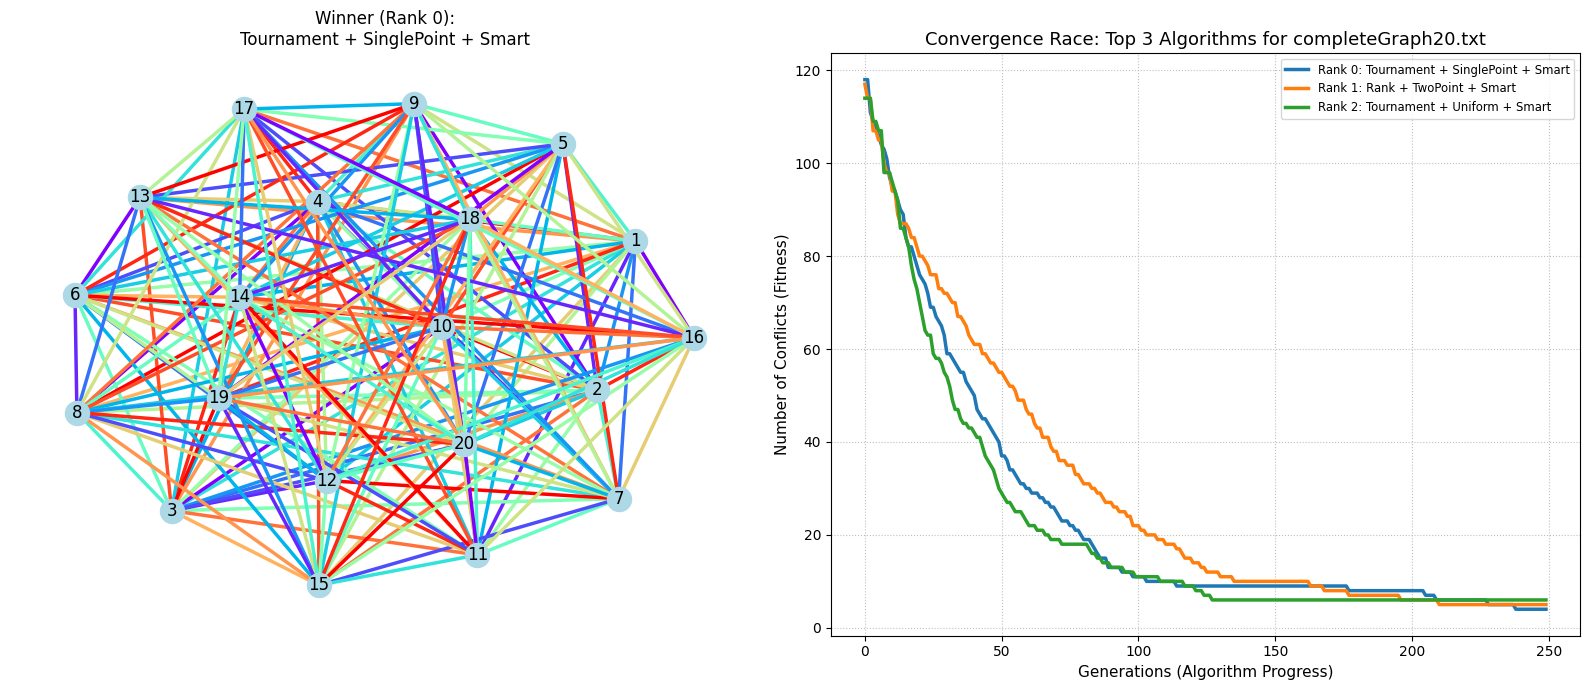

Full table saved to: resultsGA/completeGraph20.txt

>>> ANALYZING: flowerSnark.txt
[TYPE]: SNARK / Petersen Graph
[THEORY]: Class 2 (Expected χ' = Δ + 1 = 4)
Top 3 Combinations for flowerSnark.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │             0 │         3 │ 0.018331 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ SinglePoint │ Smart      │             0 │         3 │ 0.020523 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │             0 │         3 │ 0.021638 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════

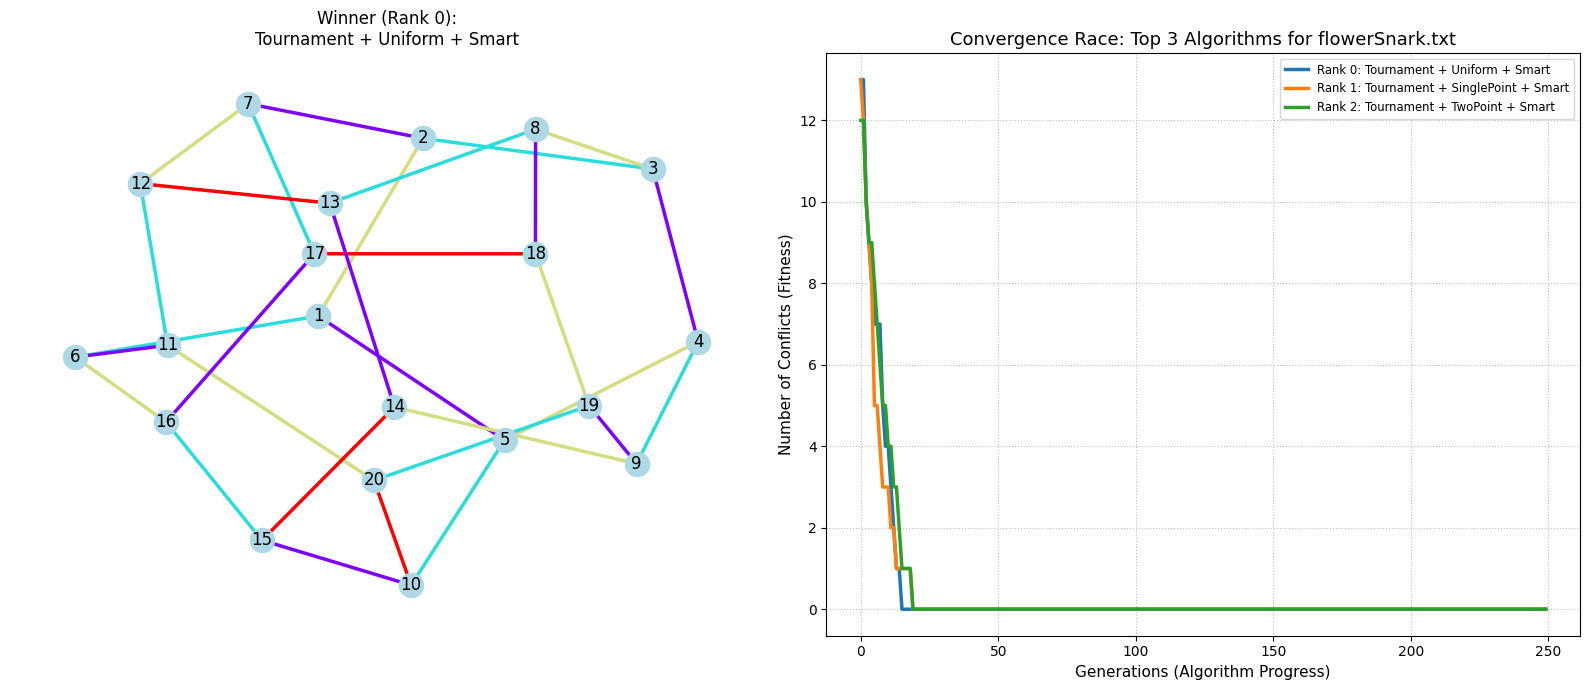

Full table saved to: resultsGA/flowerSnark.txt

>>> ANALYZING: gcol.txt
[TYPE]: Unknown Graph Type
!!! Nema nule sa 61 boja. Pokrećem Delta + 1 = 62...
Top 3 Combinations for gcol.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │           769 │        62 │  9.7858  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Rank        │ Uniform     │ Smart      │           879 │        62 │ 10.308   │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │           964 │        62 │  7.09856 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧════════

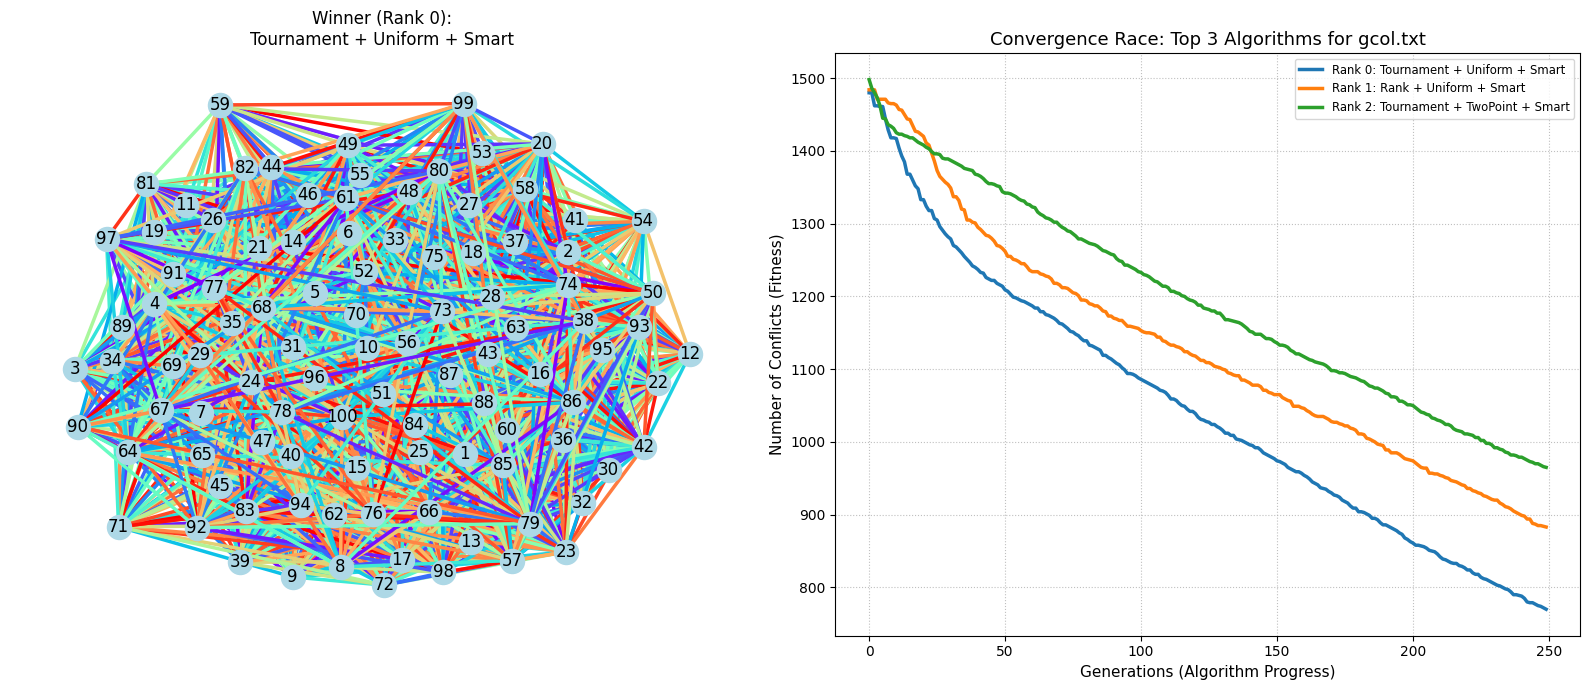

Full table saved to: resultsGA/gcol.txt

>>> ANALYZING: graph100_0.5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
!!! Nema nule sa 64 boja. Pokrećem Delta + 1 = 65...
Top 3 Combinations for graph100_0.5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │           690 │        65 │ 10.0665  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Rank        │ Uniform     │ Smart      │           760 │        65 │ 10.0534  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Swap       │           853 │        65 │  8.98691 │
╘════════╧═════════════╧════════════

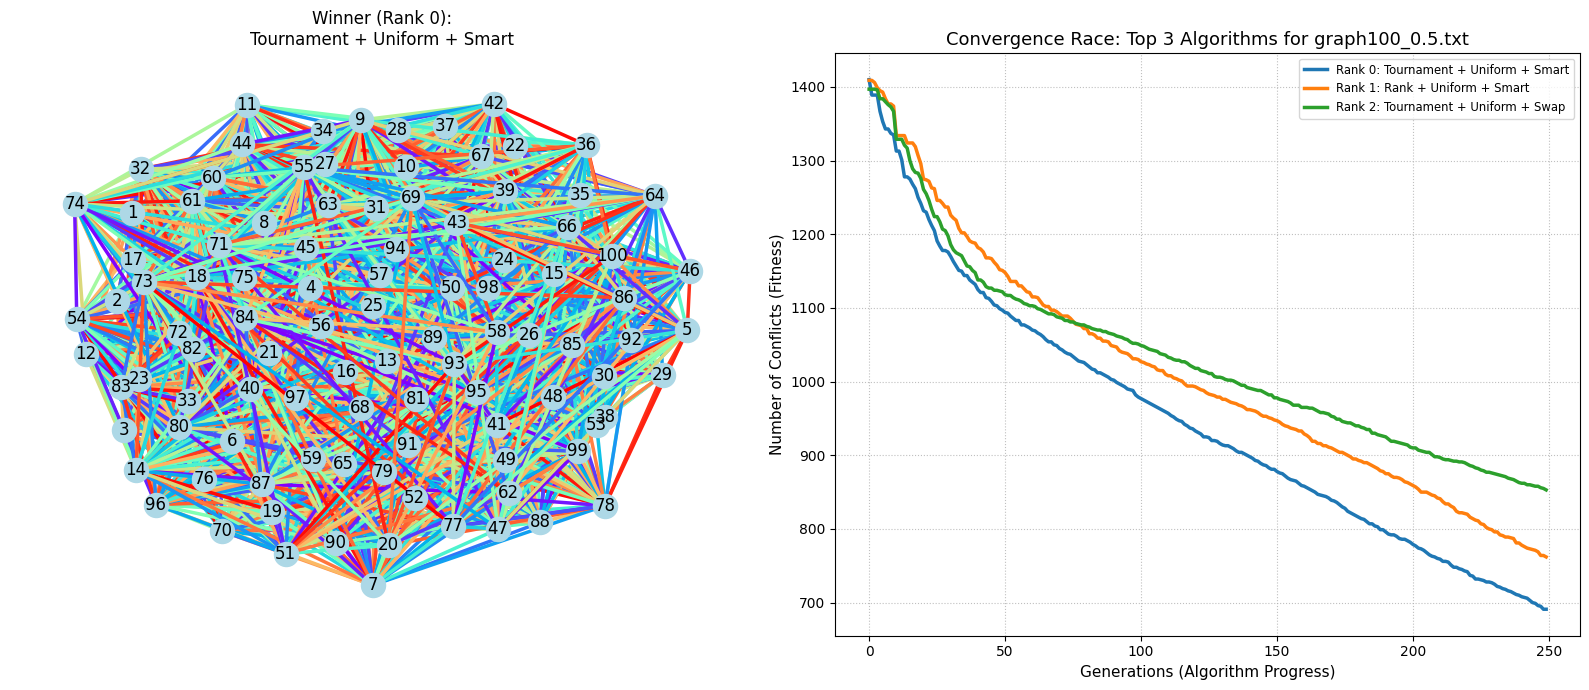

Full table saved to: resultsGA/graph100_0.5.txt

>>> ANALYZING: graph40_0.8.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
!!! Nema nule sa 35 boja. Pokrećem Delta + 1 = 36...
Top 3 Combinations for graph40_0.8.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │            11 │        36 │ 2.35762 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │            29 │        36 │ 2.81991 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │            32 │        36 │ 1.68721 │
╘════════╧═════════════╧═════════════╧

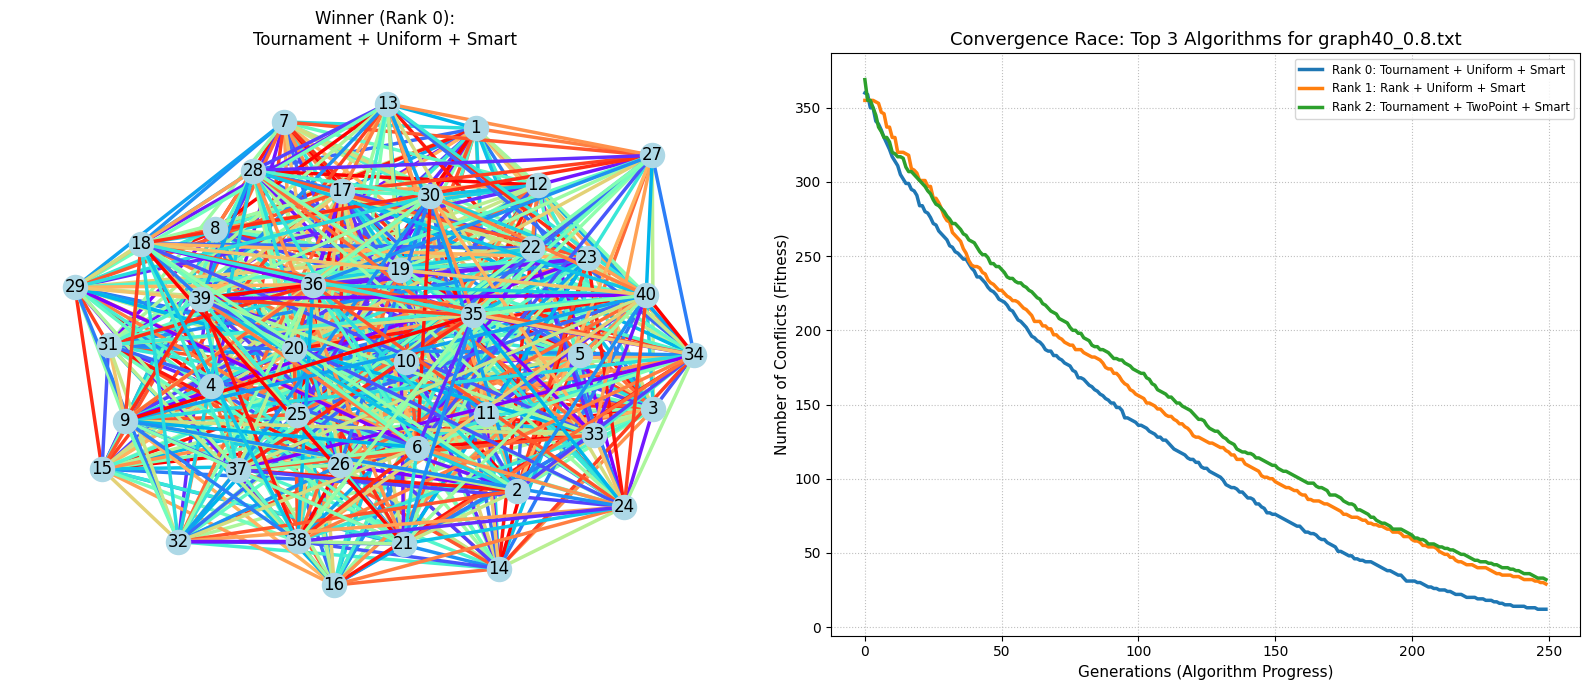

Full table saved to: resultsGA/graph40_0.8.txt

>>> ANALYZING: graph50_0.5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
!!! Nema nule sa 32 boja. Pokrećem Delta + 1 = 33...
Top 3 Combinations for graph50_0.5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │             9 │        33 │ 2.45627 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │            21 │        33 │ 2.86968 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │            46 │        33 │ 1.80171 │
╘════════╧═════════════╧═════════════╧═

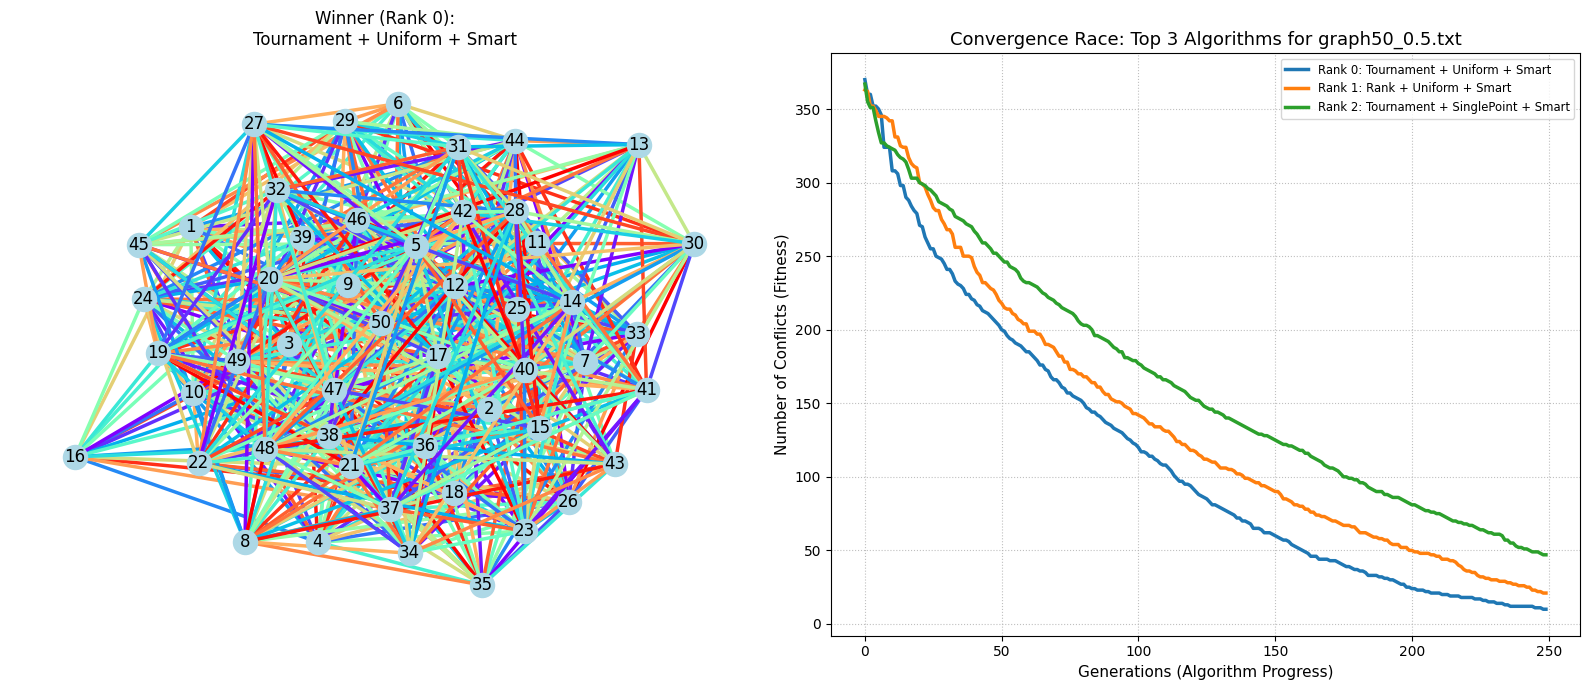

Full table saved to: resultsGA/graph50_0.5.txt

>>> ANALYZING: petersen.txt
[TYPE]: SNARK / Petersen Graph
[THEORY]: Class 2 (Expected χ' = Δ + 1 = 4)
Top 3 Combinations for petersen.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ TwoPoint    │ Random     │             0 │         3 │ 0.005137 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Roulette    │ SinglePoint │ Smart      │             0 │         3 │ 0.006088 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │             0 │         3 │ 0.006584 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧═════

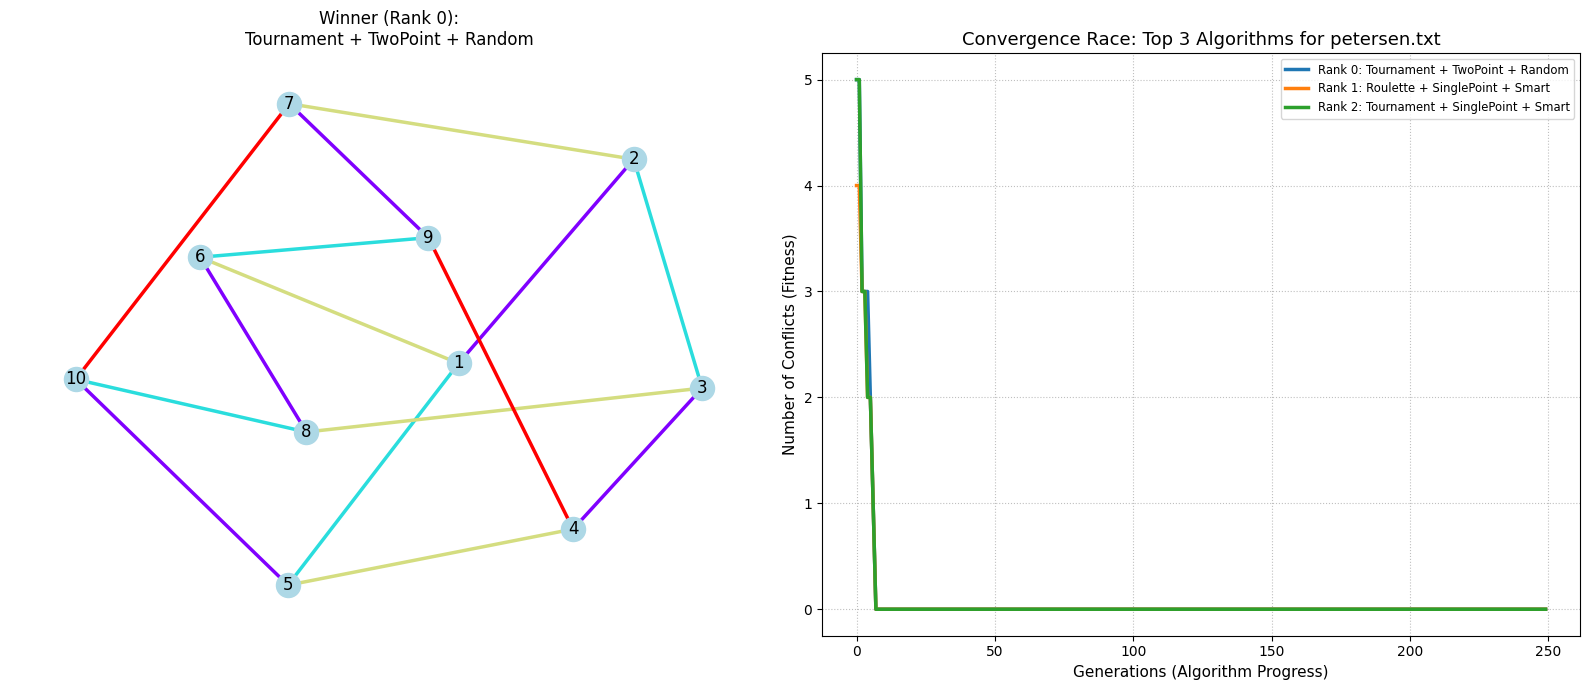

Full table saved to: resultsGA/petersen.txt

>>> ANALYZING: randomGraph5_50.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
!!! Nema nule sa 5 boja. Pokrećem Delta + 1 = 6...
Top 3 Combinations for randomGraph5_50.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         6 │ 0.137125 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Tournament  │ TwoPoint    │ Smart      │             0 │         6 │ 0.143081 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Smart      │             0 │         6 │ 0.267902 │
╘════════╧═════════════╧════

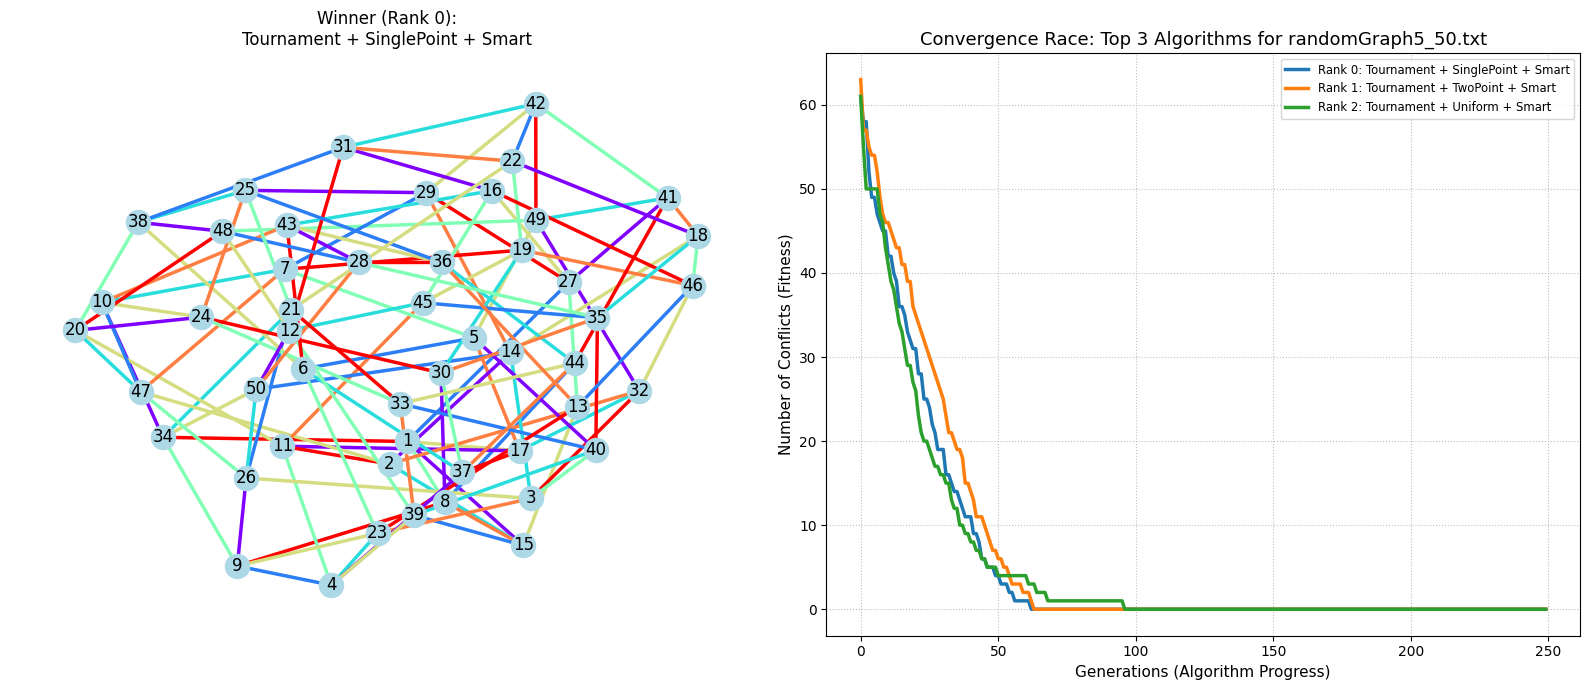

Full table saved to: resultsGA/randomGraph5_50.txt

>>> ANALYZING: randomGraph6_30.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph6_30.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         6 │ 0.294539 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      1 │ Roulette    │ SinglePoint │ Smart      │             1 │         6 │ 0.407219 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │             1 │         6 │ 0.416337 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═════

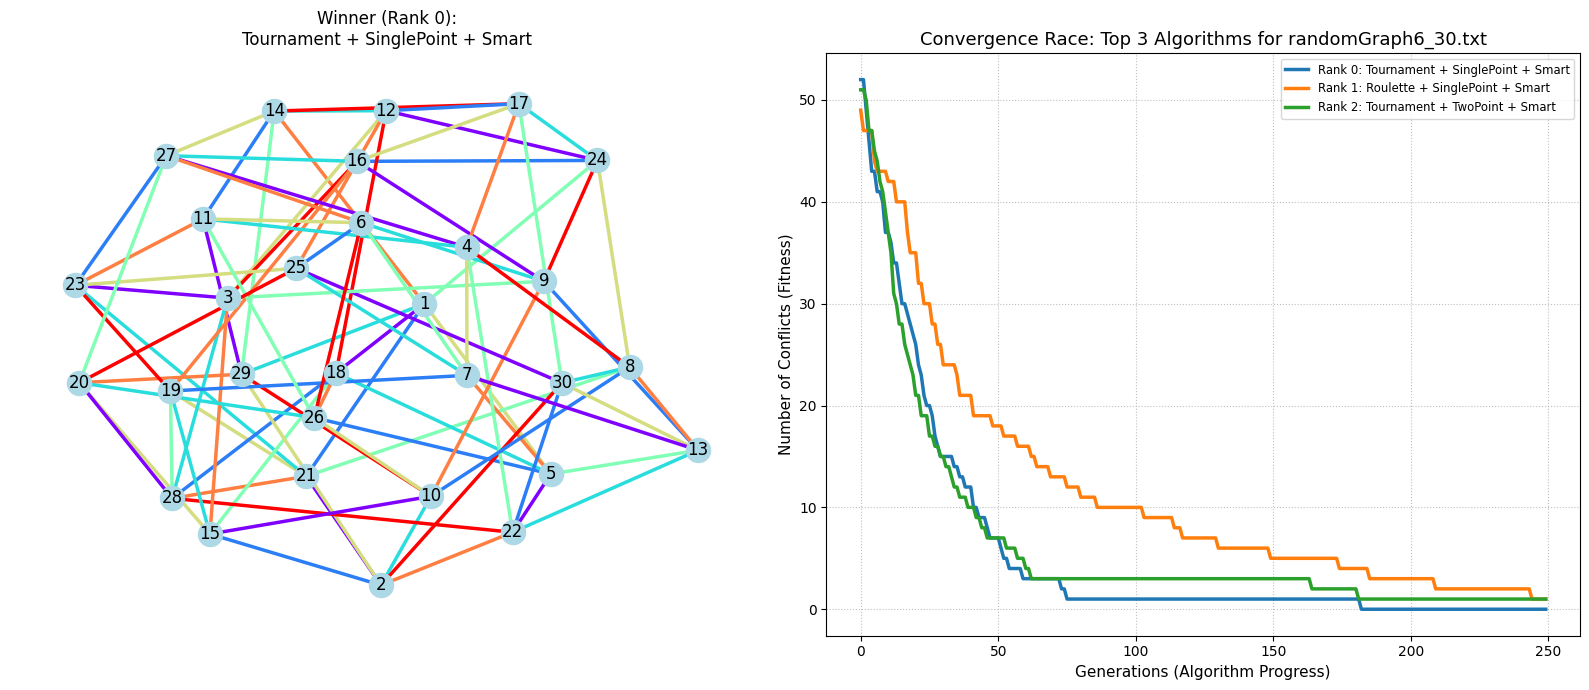

Full table saved to: resultsGA/randomGraph6_30.txt

>>> ANALYZING: randomGraph6_90.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
!!! Nema nule sa 6 boja. Pokrećem Delta + 1 = 7...
Top 3 Combinations for randomGraph6_90.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │             2 │         7 │ 1.02469 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ SinglePoint │ Smart      │             2 │         7 │ 1.35588 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Rank        │ Uniform     │ Smart      │             2 │         7 │ 1.63778 │
╘════════╧═════════════╧═════

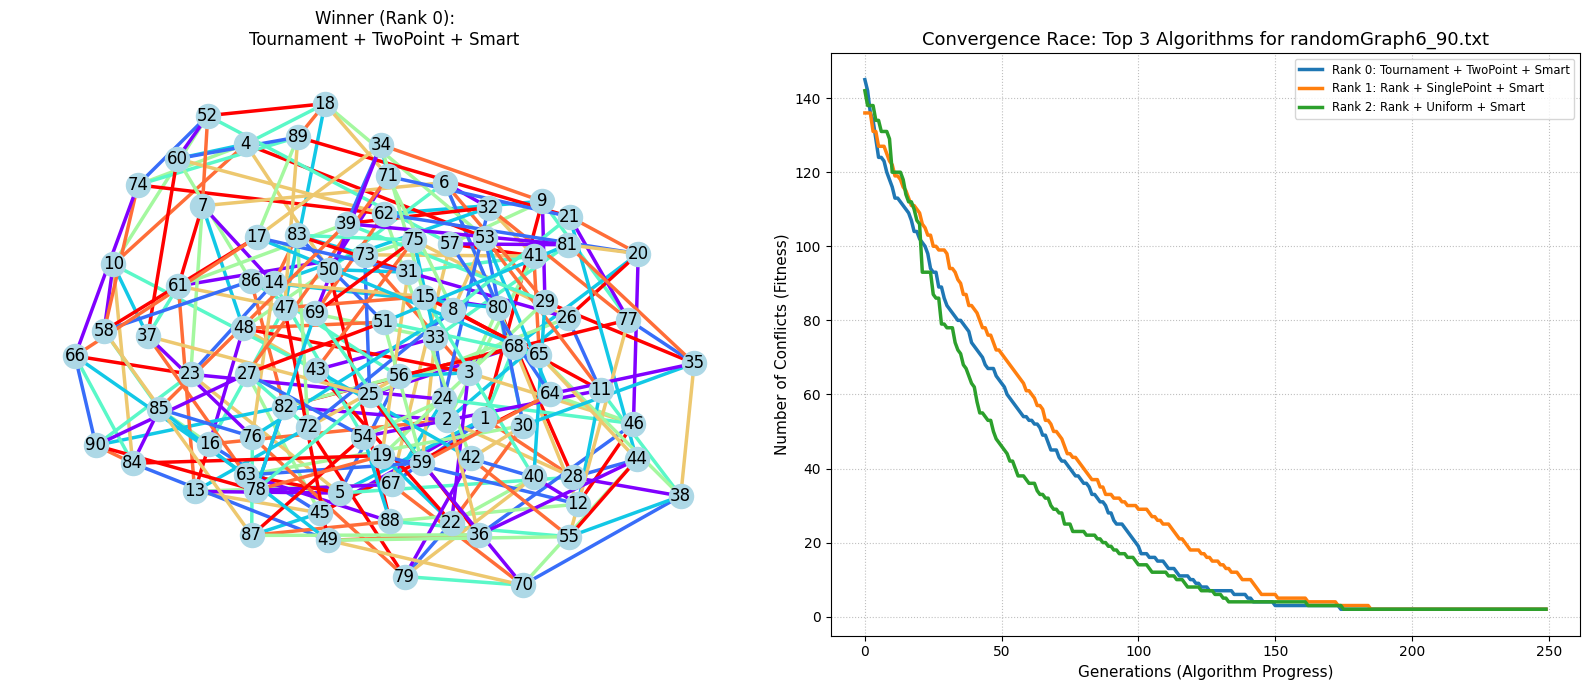

Full table saved to: resultsGA/randomGraph6_90.txt


In [17]:
#Novo ucitavanje fajla

targetFolders = ['experimentalTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)